<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/seattle_bicycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [57]:
# 後からDateがindexで日時だと分かったため、オプションを追加して時系列データとして読み込むように変更
data = pd.read_csv("https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD", index_col="Date", parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [31]:
data.describe()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
count,143608.000000,143608.000000,143608.000000
mean,111.162735,50.547616,60.615119
std,141.443433,65.157096,87.921215
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


In [32]:
data.columns = ['Total', 'East', 'West']
data.dropna().describe()

,Total,East,West
count,143608.000000,143608.000000,143608.000000
mean,111.162735,50.547616,60.615119
std,141.443433,65.157096,87.921215
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


Text(0, 0.5, 'Hourly Bicycle Count')

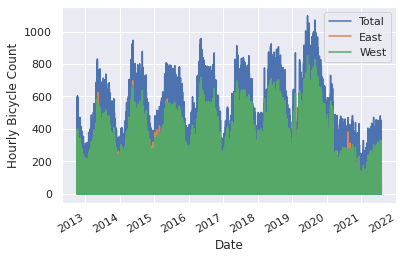

In [33]:
data.plot()
plt.ylabel('Hourly Bicycle Count')

2020年以降はコロナの影響で交通量が激減しているのが分かる

Text(0, 0.5, 'Weekly Bicycle Count')

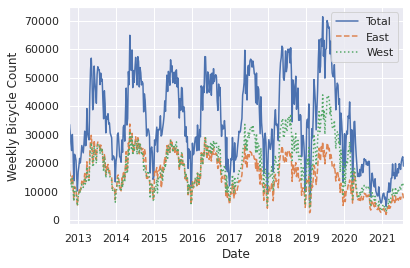

In [34]:
# データの粒度が細かすぎるため、粗い粒度で再サンプリングする
weekly = data.resample('W').sum()
weekly.plot(style=['-', '--', ':'])
plt.ylabel('Weekly Bicycle Count')

Text(0, 0.5, 'Mean Daily Count')

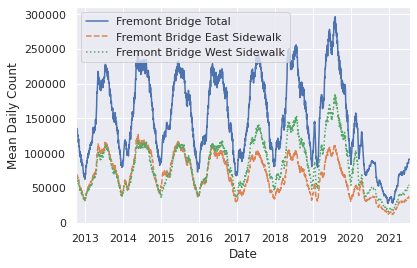

In [58]:
# 30日間の移動平均
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=['-', '--', ':'])
plt.ylabel('Mean Daily Count')

Text(0, 0.5, 'Mean Daily Count by Gaussian')

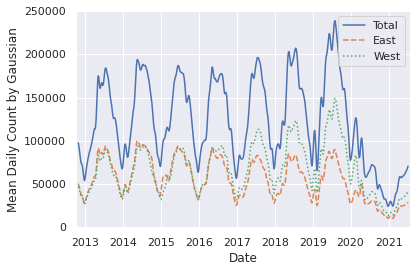

In [36]:
# ガウス窓を適用して滑らかな移動平均を求める
# ガウシアンフィルタをかけるのに必要な標準偏差は、sum(std)として入力する
daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(style=['-', '--', ':'])
plt.ylabel('Mean Daily Count by Gaussian')

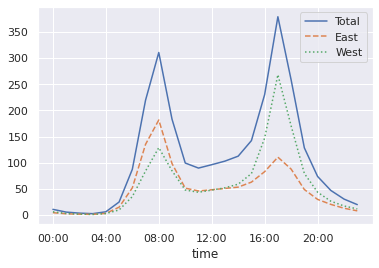

In [37]:
# 次は細かい粒度で解析する
# 時間ごとにgroupbyで集約する
by_time = data.groupby(data.index.time).mean()
# np.arange()は数列を生成する
# hourly_ticksは4時間間隔6要素(1日分)の配列
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'])

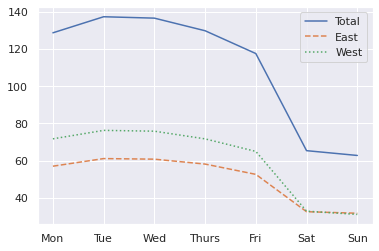

In [38]:
# 曜日ごとに同様の集約を行う
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'])

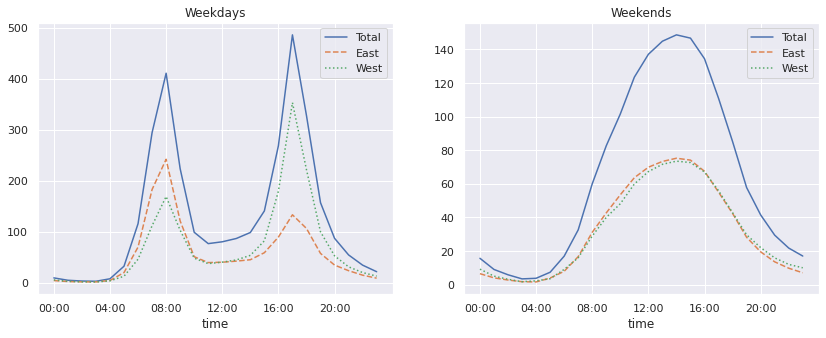

In [39]:
# 平日の交通量が週末の2倍以上であることが分かった
# 次は平日と週末の時間的傾向を可視化する
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=['-', '--', ':'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=['-', '--', ':'])

平日は通勤、帰宅による交通量が多いが、週末はレクリエーションなどのために昼間にかけての交通量の増加が見られる

In [59]:
# 天気との関係から交通量を予測する
weather = pd.read_csv('https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,WSF2,WSF5,FMTM,WT14,WT01,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,89,112,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,130,179,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,54,67,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,107,148,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,107,165,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [60]:
# daily = data.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
# 他の列を削除する
daily = daily[['Total']]
daily.head()

,Total
Date,
2012-10-03,14084.0
2012-10-04,13900.0
2012-10-05,12592.0
2012-10-06,8024.0
2012-10-07,8568.0


In [61]:
# 曜日を示すバイナリ列を追加
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
  daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [62]:
# 休日と平日の指標を追加
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2021')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8.0, 17.0)

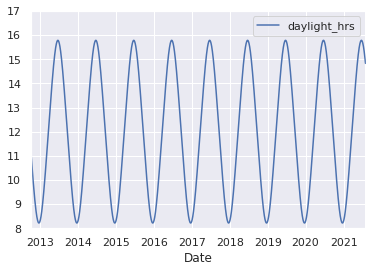

In [63]:
# 昼の時間の長さを追加
from datetime import datetime
def hours_of_daylight(date, axis=23.44, latitude=47.61):
  days = (date - datetime(2000, 12, 21)).days
  m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
  return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [64]:
# 平均気温と降水量のデータを追加
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp(C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp(C)', 'dry day']])

In [65]:
# 初日を1日として経過年数を表すカウンターを追加
daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp(C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [66]:
from sklearn.linear_model import LinearRegression

# 線形回帰モデルに当てはめる
daily.dropna(axis=0, how='any', inplace=True)

column_names = daily.columns[1:]
X = daily[column_names]
y = daily['Total']

# 曜日のフラグは独自の曜日指定切片として動作するため、fit_intercept=False
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

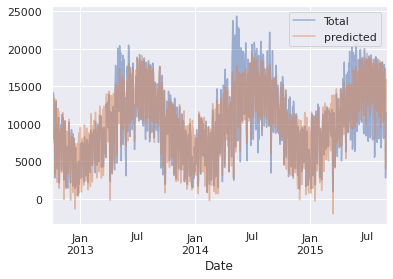

In [67]:
daily[['Total', 'predicted']].plot(alpha=0.5)

夏にかけて予測がはずれがちになっている

In [68]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             2019.531023
Tue             2440.935744
Wed             2370.694566
Thu             1929.432461
Fri              711.921382
Sat            -4413.206842
Sun            -4534.268983
holiday        -4749.605523
daylight_hrs     515.406045
PRCP           -2659.339527
Temp(C)          260.651164
dry day         2190.794369
annual           107.770852
dtype: float64

In [69]:
# ブートストラップ再サンプリング
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

              effect  error
Mon           2020.0  345.0
Tue           2441.0  333.0
Wed           2371.0  331.0
Thu           1929.0  341.0
Fri            712.0  324.0
Sat          -4413.0  318.0
Sun          -4534.0  332.0
holiday      -4750.0  653.0
daylight_hrs   515.0   36.0
PRCP         -2659.0  249.0
Temp(C)        261.0   14.0
dry day       2191.0  133.0
annual         108.0   71.0




*   日中の時間が1時間増えると、515±36人が自転車を使用する
*   降水量が1インチ増えると、2659±249人が自転車を使わなくなる
*   雨が降らない日は261±14人が自転車を使うようになる
*   毎年自転車の利用者数は108±71人増えている

